In [ ]:
!rm -rf qber-forecasting
!rm -rf deep_qber
!git clone https://github.com/rmnigm/qber-forecasting.git
!cp -r qber-forecasting/deep_qber deep_qber

In [ ]:
!pip install catboost
!pip install pytorch_lightning

In [4]:
import os
import random
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from tqdm import tqdm

import sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler, QuantileTransformer
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, recall_score, precision_score

import catboost
from catboost import Pool, CatBoostRegressor, CatBoostClassifier

In [8]:
from deep_qber.utils import OutlierDetector

In [55]:
def get_features_df(dataframe, look_back=5, train_size=0.75):
    dataset = dataframe.values
    columns = list(dataframe.columns)
    train_size = int(len(dataset) * train_size)
    test_size = len(dataset) - train_size
    data_train, data_test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
    print(f"Training set size = {train_size}, testing set size = {test_size}")

    length = data_train.shape[0]
    width = data_train.shape[1]
    x = np.empty((length, look_back + 1, width))
    for i in range(look_back, length):
        x[i] = data_train[(i - look_back):(i + 1), :]

    train_df = pd.DataFrame()
    for i, col in enumerate(columns):
        for lag in range(look_back + 1):
            feature_name = f'{col}_{look_back - lag}_lag'
            train_df[feature_name] = x[look_back:, lag, i]

    length = data_test.shape[0]
    width = data_test.shape[1]
    x = np.empty((length, look_back + 1, width))
    for i in range(look_back, length):
        x[i] = data_train[(i - look_back):(i + 1), :]

    test_df = pd.DataFrame()
    for i, col in enumerate(columns):
        for lag in range(look_back + 1):
            feature_name = f'{col}_{look_back - lag}_lag'
            test_df[feature_name] = x[look_back:, lag, i]

    return train_df, test_df

In [65]:
pulses_stats_file_path = "/content/qber-forecasting/datasets/data.csv"
dataframe = pd.read_csv(pulses_stats_file_path,
                        usecols=range(1, 8),
                        engine='python',
                        )
# dataframe = dataframe[0:100000]
dataset = dataframe.values.astype('float32')

In [66]:
outl = OutlierDetector(window_size=100, alpha=6)
no_outliers = outl.fit_transform(dataframe['e_mu_current'].values)


outliers = np.array(no_outliers) != dataframe['e_mu_current'].values
dataframe['outliers'] = outliers.astype(int)

print()
print(f'Total = {outliers.sum()}')
print(f'Frequency = {outliers.mean()}')

100%|██████████| 184750/184750 [01:14<00:00, 2483.54it/s]

Total = 591
Frequency = 0.0031971869083040304


In [75]:
train_size = 0.75
look_back = 4
target_index = 0
x_train, x_test = get_features_df(dataframe, train_size=train_size, look_back=look_back)

Training set size = 138637, testing set size = 46213


In [76]:
drop_cols = ['e_mu_current_0_lag'] + [f'outliers_{k}_lag' for k in range(5)]
target_col_name = 'outliers_0_lag'

train_pool = Pool(x_train.drop(columns=drop_cols), x_train[target_col_name])
test_pool = Pool(x_test.drop(columns=drop_cols), x_test[target_col_name])

In [77]:
model = CatBoostClassifier()

model.fit(train_pool, eval_set=test_pool)
preds = model.predict(test_pool)

28:	learn: 0.0033877	test: 0.0018157	best: 0.0018157 (28)	total: 1.39s	remaining: 46.6s
29:	learn: 0.0033571	test: 0.0017790	best: 0.0017790 (29)	total: 1.43s	remaining: 46.3s
30:	learn: 0.0033288	test: 0.0017503	best: 0.0017503 (30)	total: 1.48s	remaining: 46.4s
31:	learn: 0.0033122	test: 0.0017394	best: 0.0017394 (31)	total: 1.53s	remaining: 46.2s
32:	learn: 0.0032838	test: 0.0017326	best: 0.0017326 (32)	total: 1.57s	remaining: 46.1s
33:	learn: 0.0032595	test: 0.0017195	best: 0.0017195 (33)	total: 1.63s	remaining: 46.4s
34:	learn: 0.0032378	test: 0.0016978	best: 0.0016978 (34)	total: 1.68s	remaining: 46.4s
35:	learn: 0.0032251	test: 0.0016953	best: 0.0016953 (35)	total: 1.73s	remaining: 46.2s
36:	learn: 0.0032152	test: 0.0016925	best: 0.0016925 (36)	total: 1.78s	remaining: 46.3s
37:	learn: 0.0032028	test: 0.0016873	best: 0.0016873 (37)	total: 1.82s	remaining: 46.2s
38:	learn: 0.0031819	test: 0.0016655	best: 0.0016655 (38)	total: 1.87s	remaining: 46.1s
39:	learn: 0.0031634	test: 0.001

In [78]:
for metric in (f1_score, accuracy_score, roc_auc_score, recall_score, precision_score):
    print(f'{metric.__name__} value:')
    print(f'{metric(preds, x_test[target_col_name]):.3f}')

f1_score value:
1.000
accuracy_score value:
1.000
roc_auc_score value:
1.000
recall_score value:
1.000
precision_score value:
1.000


In [79]:
plotting_data = {
    'predicted': preds,
    'actual': x_test[target_col_name],
    'value': x_test['e_mu_current_0_lag']
    }

plotting_data = pd.DataFrame(plotting_data).reset_index()
plotting_data['missed'] = plotting_data['predicted'] != plotting_data['actual']

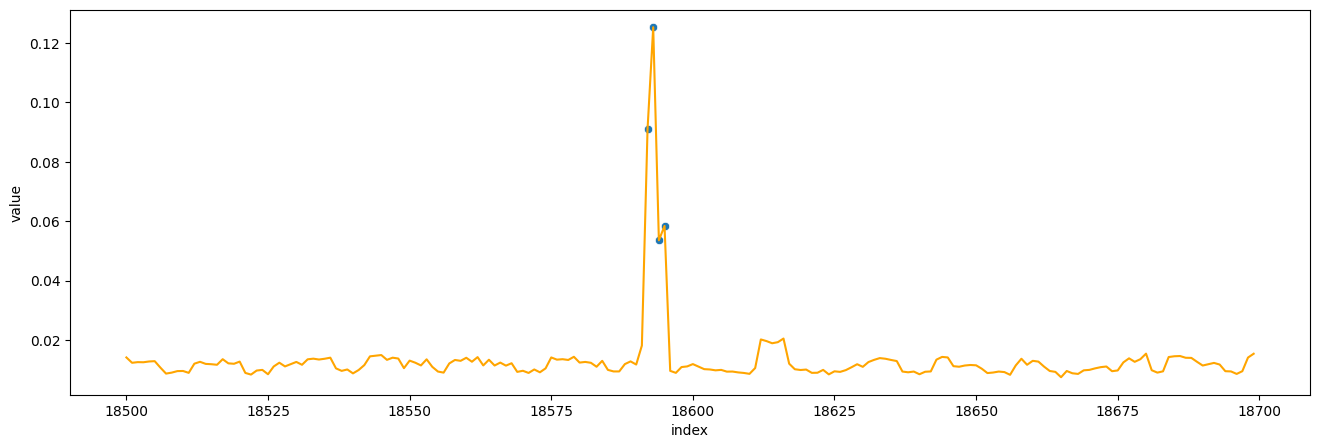

In [101]:
df = plotting_data[18500:18700]
fig, ax = plt.subplots(figsize=(16, 5))
sns.lineplot(data=df, x='index', y='value', ax=ax, color='orange')
sns.scatterplot(data=df[df['actual']==1], x='index', y='value', ax=ax)
plt.show()

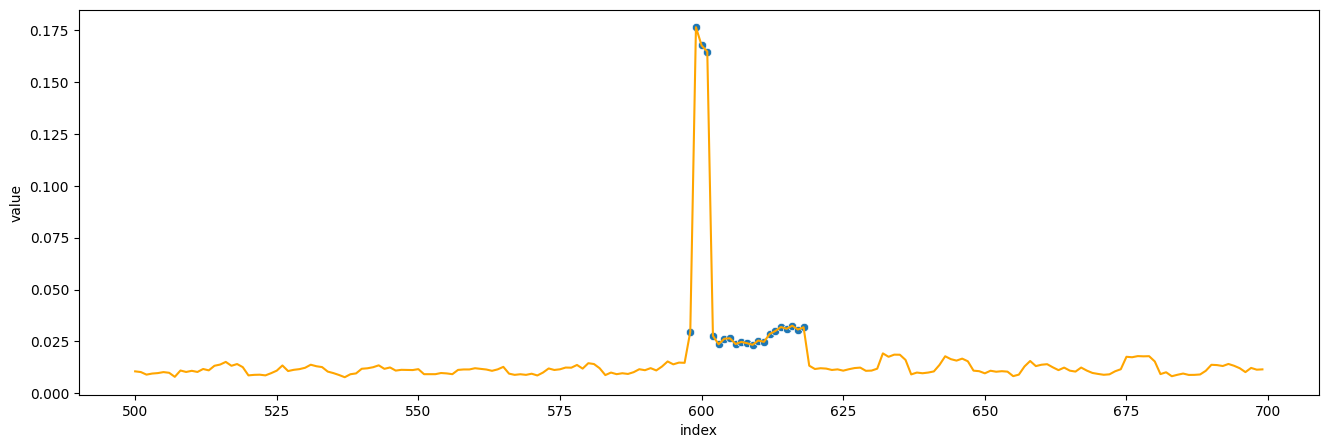

In [107]:
df = plotting_data[500:700]
fig, ax = plt.subplots(figsize=(16, 5))
sns.lineplot(data=df, x='index', y='value', ax=ax, color='orange')
sns.scatterplot(data=df[df['actual']==1], x='index', y='value', ax=ax)
plt.show()

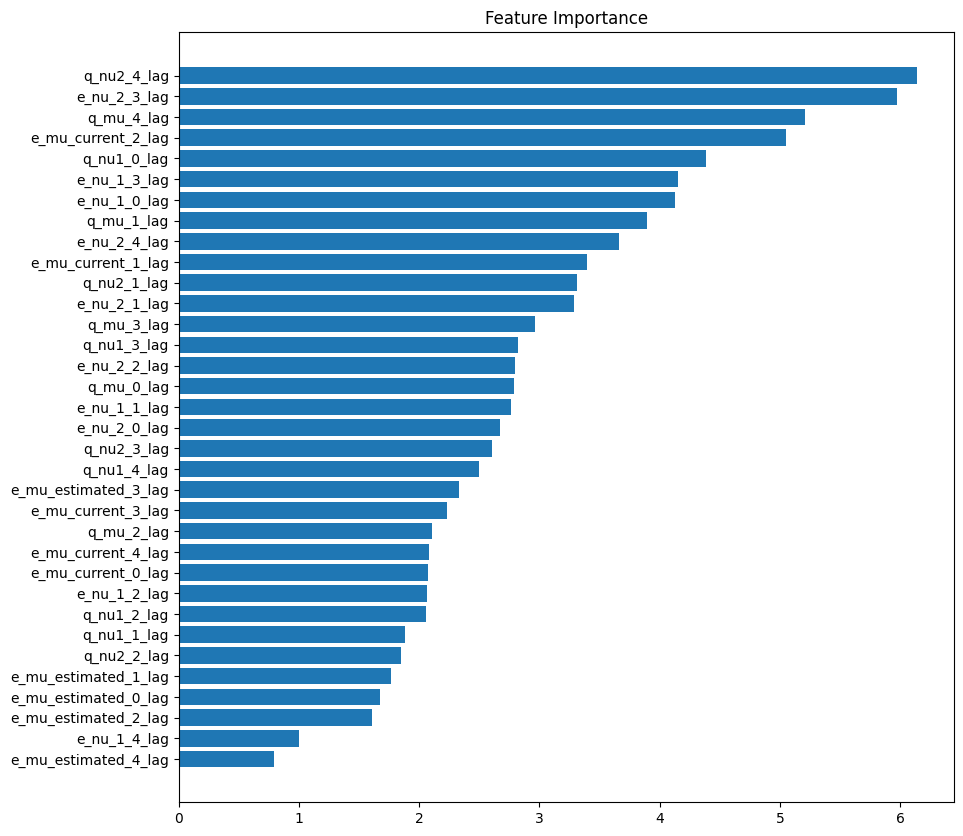

In [82]:
feature_importance = model.get_feature_importance()
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(10, 10))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(x_train.columns)[sorted_idx])
plt.title('Feature Importance')
plt.show()